In [2]:
import pandas as pd
import ast
from ast import literal_eval
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statistics
import networkx as nx
from collections import Counter, defaultdict
import matplotlib.cm as cm
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import modularity
import pandas as pd
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import os
from itertools import combinations
from networkx.algorithms.community import louvain_communities, girvan_newman, k_clique_communities
import pickle



# Importing Data 

In [3]:
merged_df = pd.read_csv('C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/papers_v2_basic.csv', encoding='utf-8')
merged_df['Parsed_BERTopic'] = merged_df['Topic_Counter']
merged_df = merged_df[['fileMain_s','Parsed_TopicsLDA', 'Parsed_BERTopic', 'numChunks', 'releasedDateY_i', 'Gender_Numeric_Avg', 'First_Gender_Value', 'Last_Gender_Value']]
merged_df

,fileMain_s,Parsed_TopicsLDA,Parsed_BERTopic,numChunks,releasedDateY_i,Gender_Numeric_Avg,First_Gender_Value,Last_Gender_Value
0,https://cnrs.hal.science/hal-03755748/document,"{'L4': 25, 'L10': 19, 'L12': 8, 'L21': 22, 'L3...",{'B61': 1},1,2022,-0.555556,1.0,-1.0
1,https://hal.science/hal-01296551/document,"{'L29': 4, 'L30': 5, 'L32': 7, 'L47': 67, 'L57...",{'B-1': 1},1,2016,-0.333333,1.0,-1.0
2,https://hal.science/hal-00870744/document,"{'L19': 6, 'L30': 7, 'L47': 85}",{'B-1': 1},1,2013,-1.000000,-1.0,-1.0
3,https://hal.science/hal-00949680/document,"{'L21': 5, 'L38': 16, 'L46': 13, 'L50': 64}",{'B5': 1},1,2014,0.000000,-1.0,0.0
4,https://hal.inrae.fr/hal-02699278/document,"{'L9': 11, 'L19': 8, 'L38': 6, 'L39': 32, 'L56...",{'B-1': 1},1,2020,-0.833333,-0.5,-1.0
...,...,...,...,...,...,...,...,...
1003,https://hal.science/hal-03362851/document,"{'L8': 4, 'L17': 8, 'L21': 72, 'L38': 2, 'L48'...","{'B60': 1, 'B2': 26, 'B-1': 10, 'B1': 4, 'B22'...",47,2021,-0.442308,1.0,-1.0
1004,https://hal.science/hal-03004624/document,"{'L12': 4, 'L14': 8, 'L16': 1, 'L18': 2, 'L29'...","{'B5': 1, 'B-1': 45, 'B4': 5, 'B1': 1, 'B40': ...",54,2020,-0.642857,-1.0,-0.5
1005,https://hal.inrae.fr/hal-04429206/document,"{'L45': 3, 'L66': 96}","{'B60': 2, 'B2': 17, 'B-1': 36, 'B1': 1, 'B14'...",57,2024,-0.130435,1.0,1.0
1006,https://hal.science/hal-03121578/document,{'L33': 100},"{'B-1': 96, 'B4': 7, 'B14': 1}",104,2021,-0.571429,1.0,-1.0


In [4]:
type(merged_df['Parsed_TopicsLDA'])

pandas.core.series.Series

In [5]:
type(merged_df['Parsed_BERTopic'])

pandas.core.series.Series

In [7]:
print(merged_df['Parsed_BERTopic'][1005])

{'B60': 2, 'B2': 17, 'B-1': 36, 'B1': 1, 'B14': 1}


In [8]:
def convert_to_dict(series):
    return series.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert the columns to dictionaries
merged_df['Parsed_BERTopic'] = convert_to_dict(merged_df['Parsed_BERTopic'])
merged_df['Parsed_TopicsLDA'] = convert_to_dict(merged_df['Parsed_TopicsLDA'])

In [9]:
type(merged_df['Parsed_BERTopic'][1005])

dict

# Networks Construction


In [1]:
#----FUNCTIONS USED

#------Functions to build graphs

def save_graph_pickle(graph, filename):
    """
    Save the graph to a file using pickle.
    """
    with open(filename, 'wb') as file:
        pickle.dump(graph, file)
    print(f"Graph saved to {filename}")


def graph_to_dataframe(G):
    node_attributes = dict(G.nodes(data=True))
    node_attributes_df = pd.DataFrame.from_dict(node_attributes, orient='index')
    node_attributes_df.reset_index(inplace=True)
    node_attributes_df.rename(columns={'index': 'Node'}, inplace=True)
    node_attributes_df.to_csv('test_tableau_phyl.csv', index=False)
    return node_attributes_df

#-----Functions to calculate meassures

import time
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities, girvan_newman, k_clique_communities
from collections import Counter
import numpy as np
import pandas as pd

# New attributes for scoring
score_attributes = ['first_author_score', 'team_score', 'last_author_score']

def detect_communities(G2, method='louvain', community_parameter=3, graph_name='Entities'):

    G = G2.copy()
        
    # Clear existing community data for this method
    nx.set_node_attributes(G, {method: []}, method)  # Resets the attribute for all nodes
    

    
    # Remove isolated nodes from the graph and print the count of removed nodes
    isolated_nodes = list(nx.isolates(G))
    num_isolated = len(isolated_nodes)
    G.remove_nodes_from(isolated_nodes)
    print(f"Removed {num_isolated} isolated nodes from the graph.")
    
    # Print the remaining number of nodes
    num_remaining_nodes = G.number_of_nodes()
    print(f"Remaining nodes in the graph: {num_remaining_nodes}")

    # Proceed with community detection
    start_time = time.time()  # Start timing

    if method == 'louvain':
        # Using edge weights in Louvain method
        communities = louvain_communities(G, weight='weight')
    elif method == 'girvan_newman':
        comp = girvan_newman(G)
        limited = itertools.islice(comp, community_parameter - 1)
        for communities in limited:
            pass
        communities = list(sorted(c) for c in communities)
    elif method == 'k_clique':
        communities = list(k_clique_communities(G, community_parameter))
        communities = [list(community) for community in communities]
    else:
        raise ValueError("Unsupported community detection method")

    # Timing the community detection
    elapsed_time = time.time() - start_time
    print(f"Community detection {method} took {elapsed_time:.2f} seconds.")
    
    community_nodes = {f"Community {i}": community for i, community in enumerate(communities)}

    # Annotate nodes with their communities
    for community_id, nodes in community_nodes.items():
        for node in nodes:
            if G.nodes[node].get(method):
                G.nodes[node][method] = [community_id]  # Replace with new community ID
            else:
                G.nodes[node][method] = [community_id]  # Initialize if not present

                
                
    #Caluculate clustering measures            
    community_clustering_measures, clustering_measures_summary = calculate_clustering_measures_communities(G, community_nodes)


    
    
    # Plotting
    # --- Barchar

        
        #----Graph 
        
    # Detect communities and obtain the list of community sizes
    community_sizes = [len(community) for community in communities if len(community) > 0]
    average_size = np.mean(community_sizes) if community_sizes else 0
    sorted_communities = {f"Community {i}": community for i, community in enumerate(sorted(communities, key=len, reverse=True))}

    color_reference = 'first_author_score'  # Define the color_reference here

    

    # Prepare data for stacked bar chart
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 24))

    for ax, score_attr in zip(axes, score_attributes):
        stacked_data = {category: [] for category in colors.keys()}
        community_labels = []

        for community_id, nodes in sorted_communities.items():
            community_labels.append(community_id)
            categorized_counts = Counter([categorize_gender(G.nodes[node][score_attr]) for node in nodes if score_attr in G.nodes[node]])
            for category in colors.keys():
                stacked_data[category].append(categorized_counts.get(category, 0))

        bottom = np.zeros(len(community_labels))

        for category, color in colors.items():
            if category == -1:
                label = 'Male'
            elif category == -0.5:
                label = 'Mostly male'
            elif category == 0:
                label = 'Neutral'
            elif category == 0.5:
                label = 'Mostly female'
            elif category == 1:
                label = 'Female'
            ax.bar(community_labels, stacked_data[category], bottom=bottom, color=color, label=f'{label}')
            bottom += np.array(stacked_data[category])

        ax.set_xticklabels(community_labels, rotation=90)
        ax.set_title(f'Distribution of Gender in {method} Communities [{graph_name}] - {score_attr}')
        ax.set_xlabel('Community')
        ax.set_ylabel('Size')
        ax.legend(title='Gender Category', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Annotate each bar with its size
        for i, label in enumerate(community_labels):
            total_size = sum(stacked_data[category][i] for category in colors.keys())
            ax.text(i, total_size, f'{total_size}', ha='center', va='bottom', color='grey')

    plt.tight_layout()
    plt.savefig(f'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/community_gender_distributions{graph_name}_{method}.png')
    plt.show()


    #-- Clustering Meassures
    # Extracting data
    metrics1 = ['Number of Nodes', 'Number of Edges', 'Graph Cut']
    metrics2 = ['Internal Density', 'External Density', 'Modularity Score', 'Conductance', 'Clustering Coefficient']
    communities = [f"Community {i}" for i in range(len(community_clustering_measures))]

    # Preparing the data for the grouped bar chart
    data1 = {metric: [community[metric] for community in community_clustering_measures] for metric in metrics1}
    data2 = {metric: [community[metric] for community in community_clustering_measures] for metric in metrics2}
    x = np.arange(len(communities))
    width = 0.2

    # Creating a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

    # Plotting the first set of metrics
    for i, metric in enumerate(metrics1):
        bars = ax1.bar(x + i * width, data1[metric], width, label=metric)
        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

    #
    # Adding a textbox with the number of communities, isolated nodes, edges, and nodes
    num_communities = len(community_nodes)
    num_edges = G2.number_of_edges()
    num_nodes = G2.number_of_nodes()
    textstr = f'Number of Communities: {num_communities}\nNumber of Edges: {num_edges}\nNumber of Nodes: {num_nodes}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    

    # Plotting the second set of metrics
    for i, metric in enumerate(metrics2):
        bars = ax2.bar(x + i * width, data2[metric], width, label=metric)
        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_xlabel('Communities')
    ax2.set_ylabel('Values')
    ax2.set_title('Community Clustering Measures (Density, Modularity, Conductance, Clustering)')
    ax2.set_xticks(x + width * 2)
    ax2.set_xticklabels(communities, rotation=45)
    ax2.legend()

    fig.tight_layout()

    # Save the plots as a single image
    plt.savefig(f'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/clustering_meassures_{graph_name}_{method}.png')

    plt.show()

        
        
    # --- Graph Plot
    # Create a color map for the communities
    community_colors = plt.get_cmap('viridis', len(communities))
    
    # Plot the graph with community coloring
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.1, iterations=20)
    valid_pos = {k: v for k, v in pos.items() if np.isfinite(v).all()}
    #print(f'Valid pos: {valid_pos}')

    if not valid_pos:
        print("No valid node positions found.")
        return community_nodes, {}, {}, elapsed_time

    # Draw nodes with colors based on their community
    for i, community in enumerate(communities):
        community_nodes_list = [node for node in community if node in valid_pos]
        nx.draw_networkx_nodes(
            G, valid_pos, 
            nodelist=community_nodes_list, 
            node_color=[community_colors(i)]*len(community_nodes_list), 
            node_size=[G.nodes[node].get('size', 10) * 10 for node in community_nodes_list],
            alpha=0.7
        )
    
    # Draw edges
    nx.draw_networkx_edges(G, valid_pos, alpha=0.5)
    
    plt.title("Graph with Detected Communities")
    plt.axis('off')
    
    # Add textbox with number of communities and isolated nodes
    textstr = f'Number of communities: {len(communities)}\nNumber of isolated nodes: {num_isolated}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(1.05, 0.5, textstr, transform=plt.gca().transAxes, fontsize=12,
                   verticalalignment='center', bbox=props)
    
    plt.show()

    # Ensure community_nodes is a dictionary before calling the function
    if isinstance(community_nodes, dict):
        plot_all_community_stats(G, community_nodes, community_clustering_measures, title_g=f'{graph_name} [{method}]', graph_name=graph_name, method=method)
    else:
        print("Error: community_nodes is not a dictionary")

    
    print(f"Method {method} - Found {len(community_nodes)} communities: {community_nodes}")
    
    return community_nodes, community_clustering_measures, clustering_measures_summary, elapsed_time

import numpy as np
import matplotlib.pyplot as plt

score_attributes = ['first_author_score', 'team_score', 'last_author_score']




def calculate_clustering_measures_communities(original_graph, input_communities_or_subgraphs):
    data_for_df = []
    total_edges = original_graph.number_of_edges()
    total_nodes = original_graph.number_of_nodes()

    # Determine if input is a list of communities or a dictionary of subgraphs
    if isinstance(input_communities_or_subgraphs, list):
        community_list = input_communities_or_subgraphs
        use_as_communities = True
    elif isinstance(input_communities_or_subgraphs, dict):
        community_list = list(input_communities_or_subgraphs.values())
        use_as_communities = False
    else:
        raise ValueError("Input must be either a list of communities or a dictionary with node lists")

    for i, nodes in enumerate(community_list):
        subgraph = original_graph.subgraph(nodes)
        num_nodes = subgraph.number_of_nodes()
        internal_edges = subgraph.number_of_edges()
        external_edges = sum(1 for u, v in original_graph.edges() if (u in subgraph and v not in subgraph) or (u not in subgraph and v in subgraph))

        internal_density = (2 * internal_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
        possible_external_links = num_nodes * (total_nodes - num_nodes)
        external_density = external_edges / possible_external_links if possible_external_links > 0 else 0
        community_modularity = modularity(original_graph, [nodes] if use_as_communities else [set(subgraph.nodes()), set(original_graph.nodes()) - set(subgraph.nodes())])
        conductance = external_edges / (internal_edges + external_edges) if (internal_edges + external_edges) > 0 else 0
        clustering_coefficient = nx.average_clustering(subgraph)

        data_for_df.append({
            'Number of Nodes': num_nodes,
            'Number of Edges': internal_edges,
            'Internal Density': internal_density,
            'External Density': external_density,
            'Graph Cut': external_edges,
            'Modularity Score': community_modularity,
            'Conductance': conductance,
            'Clustering Coefficient': clustering_coefficient
        })

    df = pd.DataFrame(data_for_df)
    clustering_measures_summary = df.describe().drop(['count', '25%', '50%', '75%', 'std'])  # simplified statistical summary
    clustering_measures = data_for_df
    return clustering_measures, clustering_measures_summary

def analyze_multiple_community_methods(G, min_clique=3, gn_splits=3, graph_name='Entities'):
    '''
    Apply multiple community detection methods on a graph and compile their results.
    
    Args:
    G (Graph): A NetworkX graph.
    min_clique (int): Minimum size of the clique for the k-clique community detection.
    gn_splits (int): Number of splits for the Girvan-Newman method.
    graph_name (str): Name of the graph for titling purposes.

    Returns:
    Three dictionaries: 
    - dict of community nodes keyed by method,
    - dict of community clustering measures keyed by method,
    - dict of clustering measures summaries keyed by method.
    '''
    
    methods = ['louvain', 'girvan_newman', 'k_clique']
    times = []
    community_nodes_dict = {}
    community_clustering_measures_dict = {}
    clustering_measures_summary_dict = {}

    for method in methods:
        community_parameter = min_clique if method != 'girvan_newman' else gn_splits
        community_nodes, community_clustering_measures, clustering_measures_summary, elapsed_time  = detect_communities(
            G, method, community_parameter, graph_name=graph_name
        )
        times.append(elapsed_time)
        
        print(f'testing {community_clustering_measures}')
        community_nodes_dict[method] = community_nodes
        community_clustering_measures_dict[method] = community_clustering_measures
        clustering_measures_summary_dict[method] = clustering_measures_summary
        
        
     # Plotting execution times
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, times, color='skyblue')
    plt.title('Community Detection Execution Times')
    plt.xlabel('Method')
    plt.ylabel('Time (seconds)')
    plt.ylim(0, max(times) * 1.1)  # Increase ylim for better visual

    # Annotate each bar with the corresponding execution time
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, time, f'{time:.2f}s', ha='center', va='bottom')

    plt.show()



    return community_nodes_dict, community_clustering_measures_dict, clustering_measures_summary_dict
# Example usage
#order_community_nodes, order_community_clustering_measures, order_clustering_measures_summary, order_time_louvain = detect_communities(order_G, graph_name='Order')


import json


def save_to_json(data, filename):
    """
    Save the data to a JSON file.
    """
    def convert_to_serializable(obj):
        if isinstance(obj, set):
            return list(obj)
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(i) for i in obj]
        elif isinstance(obj, pd.DataFrame):
            return obj.to_dict()  # Convert DataFrame to dictionary
        return obj
    
    serializable_data = convert_to_serializable(data)
    
    with open(filename, 'w') as file:
        json.dump(serializable_data, file, indent=4)
    
    print(f"Data saved to {filename}")
    
    
def calculate_clustering_measures_communities(original_graph, input_communities_or_subgraphs):
    
    data_for_df = []
    total_edges = original_graph.number_of_edges()
    total_nodes = original_graph.number_of_nodes()

    # Determine if input is a list of communities or a dictionary of subgraphs
    if isinstance(input_communities_or_subgraphs, list):
        community_list = input_communities_or_subgraphs
        use_as_communities = True
    elif isinstance(input_communities_or_subgraphs, dict):
        community_list = list(input_communities_or_subgraphs.values())
        use_as_communities = False
    else:
        raise ValueError("Input must be either a list of communities or a dictionary with node lists")

    for i, nodes in enumerate(community_list):
        subgraph = original_graph.subgraph(nodes)
        num_nodes = subgraph.number_of_nodes()
        internal_edges = subgraph.number_of_edges()
        external_edges = sum(1 for u, v in original_graph.edges() if (u in subgraph and v not in subgraph) or (u not in subgraph and v in subgraph))

        internal_density = (2 * internal_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
        possible_external_links = num_nodes * (total_nodes - num_nodes)
        external_density = external_edges / possible_external_links if possible_external_links > 0 else 0
        community_modularity = modularity(original_graph, [nodes] if use_as_communities else [set(subgraph.nodes()), set(original_graph.nodes()) - set(subgraph.nodes())])
        conductance = external_edges / (internal_edges + external_edges) if (internal_edges + external_edges) > 0 else 0
        clustering_coefficient = nx.average_clustering(subgraph)

        data_for_df.append({
            'Number of Nodes': num_nodes,
            'Number of Edges': internal_edges,
            'Internal Density': internal_density,
            'External Density': external_density,
            'Graph Cut': external_edges,
            'Modularity Score': community_modularity,
            'Conductance': conductance,
            'Clustering Coefficient': clustering_coefficient
        })

    df = pd.DataFrame(data_for_df)
    clustering_meassures_summary = df.describe().drop(['count', '25%', '50%', '75%', 'std'])  # simplified statistical summary
    clustering_meassures = data_for_df
    return clustering_meassures, clustering_meassures_summary

def get_subgraphs_clustering_measures(original_graph, subgraph):
    from scipy.stats import mode
    ''' Function to display clustering measures values of communities or subgraphs'''
    results = {}
    data_for_df = []
    total_edges = original_graph.number_of_edges()
    total_nodes = original_graph.number_of_nodes()

    if isinstance(subgraph, list):
        community_list = subgraph
        use_as_communities = True
    elif isinstance(subgraph, dict):
        community_list = list(subgraph.values())
        use_as_communities = False
    else:
        raise ValueError("Input must be either a list of communities or a dictionary with node lists")

    for i, nodes in enumerate(community_list):
        subgraph = original_graph.subgraph(nodes)
        num_nodes = subgraph.number_of_nodes()
        internal_edges = subgraph.number_of_edges()
        external_edges = sum(1 for u, v in original_graph.edges() if (u in subgraph and v not in subgraph) or (u not in subgraph and v in subgraph))

        # Calculations for each community or subgraph
        internal_density = (2 * internal_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
        possible_external_links = num_nodes * (total_nodes - num_nodes)
        external_density = external_edges / possible_external_links if possible_external_links > 0 else 0

        if use_as_communities:
            community_modularity = modularity(original_graph, subgraph)
        else:
            rest_of_graph_nodes = set(original_graph.nodes()) - set(subgraph.nodes())
            community_modularity = modularity(original_graph, [set(subgraph.nodes()), rest_of_graph_nodes])
        conductance = external_edges / (internal_edges + external_edges) if (internal_edges + external_edges) > 0 else 0

        clustering_coefficient = nx.average_clustering(subgraph)

        data_for_df.append({
            'Number of Nodes': num_nodes,
            'Number of Edges': internal_edges,
            'Internal Density': internal_density,
            'External Density': external_density,
            'Graph Cut': external_edges,
            'Modularity Score': community_modularity,
            'Conductance': conductance,
            'Clustering Coefficient': clustering_coefficient
        })
        
        results[f'Subgraph {i}'] = data_for_df[-1]

    # DataFrame handling
    df = pd.DataFrame(data_for_df)
    numeric_df = df.select_dtypes(include=[np.number])
    summary_df = numeric_df.agg(['mean', 'max', 'min']).assign(
        Mode=lambda x: x.apply(lambda col: mode(col)[0][0] if len(mode(col)[0]) > 0 else None)
    )
    
    print(f'Subgraph clustering meassures {summary_df}')

    return results, summary_df


def calculate_centrality_measures(graph, name_complement=''):
    # Calculate Degree Centrality
    degree_centrality = nx.degree_centrality(graph)
    
    # Calculate Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    # Calculate Closeness Centrality
    closeness_centrality = nx.closeness_centrality(graph)
    
    # Calculate Eigenvector Centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        eigenvector_centrality = {node: float('nan') for node in graph.nodes()}
        print(f"Eigenvector centrality calculation did not converge for subgraph {name_complement}")
    
    # Calculate Clustering Coefficient
    clustering_coefficient = nx.clustering(graph)
    
    # Calculate Strength (for weighted networks)
    strength = {node: sum(data['weight'] for _, _, data in graph.edges(node, data=True)) for node in graph.nodes()}
    
    # Calculate Average Weight as a Function of End-Point Degree
    avg_weight_end_point_degree = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if neighbors:
            avg_weight = sum(graph[node][neighbor]['weight'] * (graph.degree(node) * graph.degree(neighbor)) for neighbor in neighbors) / len(neighbors)
        else:
            avg_weight = 0
        avg_weight_end_point_degree[node] = avg_weight
    
    # Calculate neighborhood connectivity
    neighborhood_connectivity = {}
    male_neighbors = {}
    female_neighbors = {}
    neutral_neighbors = {}
    
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        neighbor_degrees = [graph.degree(neighbor) for neighbor in neighbors]
        
        # Neighborhood Connectivity
        if neighbors:  # avoid division by zero
            neighborhood_connectivity[node] = sum(neighbor_degrees) / len(neighbor_degrees)
        else:
            neighborhood_connectivity[node] = 0

        # Calculate the percentage of male, female, and neutral neighbors
        male_count = sum(1 for n in neighbors if graph.nodes[n].get('avg_gender', 0) <= -0.5)
        female_count = sum(1 for n in neighbors if graph.nodes[n].get('avg_gender', 0) >= 0.5)
        neutral_count = sum(1 for n in neighbors if -0.5 < graph.nodes[n].get('avg_gender', 0) < 0.5)
        
        total_neighbors = len(neighbors) if neighbors else 1  # avoid division by zero
        
        male_neighbors[node] = male_count / total_neighbors
        female_neighbors[node] = female_count / total_neighbors
        neutral_neighbors[node] = neutral_count / total_neighbors
    
    # Add centrality measures, average weight, and neighbor percentages as node attributes
    nx.set_node_attributes(graph, degree_centrality, f'{name_complement}degree_centrality')
    nx.set_node_attributes(graph, betweenness_centrality, f'{name_complement}betweenness_centrality')
    nx.set_node_attributes(graph, closeness_centrality, f'{name_complement}closeness_centrality')
    nx.set_node_attributes(graph, eigenvector_centrality, f'{name_complement}eigenvector_centrality')
    nx.set_node_attributes(graph, clustering_coefficient, f'{name_complement}clustering_coefficient')
    nx.set_node_attributes(graph, strength, f'{name_complement}strength')
    nx.set_node_attributes(graph, avg_weight_end_point_degree, f'{name_complement}avg_weight_end_point_degree')
    nx.set_node_attributes(graph, neighborhood_connectivity, f'{name_complement}neighborhood_connectivity')
    nx.set_node_attributes(graph, male_neighbors, f'{name_complement}male_neighbors')
    nx.set_node_attributes(graph, female_neighbors, f'{name_complement}female_neighbors')
    nx.set_node_attributes(graph, neutral_neighbors, f'{name_complement}neutral_neighbors')

    print("Centrality measures, average weight, and neighborhood attributes added to nodes.")
    return graph







def explore_graph(graph):
    ''' Function to display centrality values, correlations of node attributes, and plot a heatmap.'''
    from scipy.stats import mode, pearsonr

   
    # Prepare a dictionary to store the attribute data
    attributes_data = {}

    print(f"Total number of nodes: {graph.number_of_nodes()}")
    print(f"Total number of edges: {graph.number_of_edges()}")

    # Collect data for each node in the graph
    for node, data in graph.nodes(data=True):
        for attr, value in data.items():
            # Check if the value is numeric; if not, print a warning and the offending data
            if isinstance(value, (int, float, np.number)):
                if attr not in attributes_data:
                    attributes_data[attr] = []
                attributes_data[attr].append(value)
            #else:
                #print(f"Non-numeric data detected: Node {node}, Attribute {attr}, Value {value}")
    #print(f"Attributes data1: {attributes_data}")
    # Ensure all attributes are numeric for centrality measures
    if 'degree_centrality' not in attributes_data:
        attributes_data['degree_centrality'] = list(nx.degree_centrality(graph).values())
    if 'betweenness_centrality' not in attributes_data:
        attributes_data['betweenness_centrality'] = list(nx.betweenness_centrality(graph).values())
    if 'closeness_centrality' not in attributes_data:
        attributes_data['closeness_centrality'] = list(nx.closeness_centrality(graph).values())

    # Convert attributes_data to DataFrame for easier manipulation
    attribute_df = pd.DataFrame(attributes_data)
    
    #print(f"Attributes data2: {attribute_df}")

    # Calculate statistical measures for each attribute
    stats_data = {}
    for attr, values in attribute_df.items():
        stats_data[attr] = {
            'Max': np.max(values),
            'Min': np.min(values),
            'Average': np.mean(values),
            'Mode': mode(values).mode[0] if len(mode(values).mode) > 0 else None
        }

    # Convert the stats data into a DataFrame
    stats_df = pd.DataFrame(stats_data).transpose()
    stats_df.columns = ['Max', 'Min', 'Average', 'Mode']

    # Calculate the correlation matrix
    correlation_matrix = attribute_df.corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Attribute Correlation Heatmap')
    plt.show()

    return stats_df, correlation_matrix




import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities, girvan_newman, k_clique_communities
import itertools
import time







#-----Functions to build graphs/subgraphs/communities

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np  # Necessary for calculations







#-----Functions for information display

def print_node_attributes(graph, node_name):
    # Check if the node exists in the graph
    if node_name in graph:
        # Retrieve and print all attributes of the node
        node_attributes = graph.nodes[node_name]
        print(f"Attributes for '{node_name}':")
        for attribute, value in node_attributes.items():
            print(f"  {attribute}: {value}")
    else:
        print(f"No node named '{node_name}' found in the graph.")



def plot_graph_with_attributes(graph, title='Graph Visualization', scale_node=2, top_labels=10, spacing_k = 0.15):
    plt.figure(figsize=(14, 10))  # Increased figure size for better visibility
    pos = nx.spring_layout(graph, k=spacing_k, iterations=50)  # Increased spacing and iterations for a better spread

    # Prepare a plot with an axis
    fig, ax = plt.subplots(figsize=(14, 10))  # Match subplot size to figure size for consistency
    
    # Draw nodes with size and color attributes
    node_sizes = [graph.nodes[node]['size'] * scale_node for node in graph.nodes()]  # Increased size scaling factor
    node_colors = [graph.nodes[node]['color'] for node in graph.nodes()]
    edge_colors = [graph.nodes[node]['border_color'] for node in graph.nodes()]

    # Draw nodes
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors, edgecolors=edge_colors, linewidths=2, alpha=0.9, ax=ax)
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos, width=1, alpha=0.4, ax=ax)  # Increased edge width for visibility
    
    # Draw labels for the top n largest nodes
    sorted_nodes = sorted(graph.nodes(data=True), key=lambda x: x[1]['size'], reverse=True)
    labels = {node[0]: node[0] for node in sorted_nodes[:top_labels]}
    nx.draw_networkx_labels(graph, pos, labels, font_size=10, ax=ax)  # Increased font size for labels
    
    # Create a color bar
    norm = plt.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    sm.set_array([])  # Necessary when only using colormap and not mappable data
    cbar = plt.colorbar(sm, orientation='horizontal', ax=ax, pad=0.1)
    cbar.set_label('Average Gender Value')

    plt.title(title)
    plt.axis('off')  # Hide the axes
    plt.show()
    
    
    
visualization_dir = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/'

def plot_top_nodes(graph, graph_title, attribute_name='size', top_n=20):
    # Ensure the graph has the specified attribute for nodes
    if not nx.get_node_attributes(graph, attribute_name):
        print(f"No '{attribute_name}' attribute found for nodes in the graph.")
        return

    graph_name = graph.name if hasattr(graph, 'name') else 'Graph'

    # Extract attribute values and sort nodes by this attribute
    node_attributes = nx.get_node_attributes(graph, attribute_name)
    
    # Compute statistics for all nodes
    all_values = list(node_attributes.values())
    min_value = min(all_values)
    max_value = max(all_values)
    avg_value = round(np.mean(all_values), 2)
    try:
        mode_value = round(mode(all_values), 2)
    except StatisticsError:
        mode_value = "No unique mode"

    # Global statistics text
    stats_text = (f"Global Min {attribute_name}: {round(min_value, 2)}\n"
                  f"Global Max {attribute_name}: {round(max_value, 2)}\n"
                  f"Global Avg {attribute_name}: {avg_value}\n"
                  f"Global Mode {attribute_name}: {mode_value}")

    # Print global statistics
    print(stats_text)
    
    top_nodes = sorted(node_attributes.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Print details of top nodes
    print("Top nodes by attribute:", attribute_name)
    for node, value in top_nodes:
        print(f"  {node}: {value}")

    # Calculate gender score statistics for top nodes
    top_gender_scores = [graph.nodes[node].get('first_author_score', 0) for node, _ in top_nodes]
    top_min_gender = round(min(top_gender_scores), 2)
    top_max_gender = round(max(top_gender_scores), 2)
    top_avg_gender = round(np.mean(top_gender_scores), 2)
    top_gender_text = (f"Min Gender Score: {top_min_gender}\n"
                       f"Max Gender Score: {top_max_gender}\n"
                       f"Avg Gender Score: {top_avg_gender}")

    # Create a subgraph of these top nodes
    top_graph = graph.subgraph([node for node, _ in top_nodes])

    # Normalize node sizes for visualization
    values = [value for _, value in top_nodes]
    min_value = min(values)
    max_value = max(values)
    
    scaled_sizes = [(value - min_value) / (max_value - min_value) * 900 + 100 if max_value != min_value else 0 for value in values]  # Scale from 100 to 1000

    # Layout and draw the subgraph
    pos = nx.spring_layout(top_graph, k=0.9, iterations=30)
    plt.figure(figsize=(12, 8))
    node_colors = [top_graph.nodes[node].get('color', 'blue') for node in top_graph.nodes()]
    edgecolors = [top_graph.nodes[node].get('border_color', 'black') for node in top_graph.nodes()]
    
    nodes = nx.draw_networkx_nodes(top_graph, pos, node_size=scaled_sizes, node_color=node_colors, edgecolors=edgecolors, linewidths=2, alpha=0.9)
    nx.draw_networkx_edges(top_graph, pos, alpha=0.2)
    nx.draw_networkx_labels(top_graph, pos, labels={node: node for node in top_graph.nodes()}, font_size=12)

    # Add gender score statistics text box
    plt.gcf().text(0.02, 0.95, top_gender_text, fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5), ha='left')

    # Color bar setup
    norm = plt.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Average Gender Score')

    plt.title(f"Top {top_n} Nodes by {attribute_name} in {graph_title}")
    plt.axis('off')

    # Plot bar chart for top nodes
    plt.figure(figsize=(14, 8))
    nodes, values = zip(*top_nodes)
    y_pos = np.arange(len(nodes))

    # Bar colors based on gender score
    bar_colors = [top_graph.nodes[node].get('color', 'blue') for node in nodes]

    plt.bar(y_pos, values, align='center', alpha=0.8, color=bar_colors, edgecolor='black')
    plt.axhline(y=avg_value, color='r', linestyle='--', linewidth=2)
    plt.text(len(values)-3, avg_value + 0.01 * max_value, f'Average: {avg_value}', color='r', va='bottom', ha='right')

    for i in range(len(values)):
        value_text = f'{values[i]:.2f}' if values[i] >= 1 else f'{values[i]:.4f}'
        plt.text(i, values[i] + 0.01 * max_value, value_text, ha='center', va='bottom')

    plt.xticks(y_pos, nodes, rotation=90)
    plt.ylabel(attribute_name)
    plt.title(f'Top {top_n} Nodes by {attribute_name} in {graph_title}')
    
    # Add stats text box
    plt.gcf().text(0.8, 0.95, stats_text, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5), ha='left')

    plt.tight_layout()
    
    # Save the combined plots as a single image
    from PIL import Image
    import io

    # Save the subgraph plot to a bytes buffer
    buf1 = io.BytesIO()
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(top_graph, k=0.9, iterations=30)
    nx.draw_networkx_nodes(top_graph, pos, node_size=scaled_sizes, node_color=node_colors, edgecolors=edgecolors, linewidths=2, alpha=0.9)
    nx.draw_networkx_edges(top_graph, pos, alpha=0.2)
    nx.draw_networkx_labels(top_graph, pos, labels={node: node for node in top_graph.nodes()}, font_size=12)
    plt.gcf().text(0.02, 0.95, top_gender_text, fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5), ha='left')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Average Gender Score')
    plt.title(f"Top {top_n} Nodes by {attribute_name} in {graph_title}")
    plt.axis('off')
    plt.savefig(buf1, format='png')
    buf1.seek(0)

    # Plot bar chart for top nodes
    buf2 = io.BytesIO()
    plt.figure(figsize=(14, 8))
    nodes, values = zip(*top_nodes)
    y_pos = np.arange(len(nodes))
    bar_colors = [top_graph.nodes[node].get('color', 'blue') for node in nodes]
    plt.bar(y_pos, values, align='center', alpha=0.8, color=bar_colors, edgecolor='black')
    plt.axhline(y=avg_value, color='r', linestyle='--', linewidth=2)
    plt.text(len(values)+1.8, avg_value , f'Avg: {avg_value}', color='r', va='bottom', ha='right')
    
    for i in range(len(values)):
        value_text = f'{values[i]:.2f}' if values[i] >= 1 else f'{values[i]:.4f}'
        plt.text(i, values[i] + 0.01 * max_value, value_text, ha='center', va='bottom', color = 'grey')
    
    plt.xticks(y_pos, nodes, rotation=90)
    plt.ylabel(attribute_name)
    plt.title(f'Top {top_n} Nodes by {attribute_name} in {graph_title}')
    plt.gcf().text(0.75, 0.9, stats_text, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5), ha='left')
    plt.tight_layout()
    plt.savefig(buf2, format='png')
    buf2.seek(0)

    # Combine both plots into a single image
    subgraph_image = Image.open(buf1)
    barchart_image = Image.open(buf2)

    combined_width = subgraph_image.width + barchart_image.width
    combined_height = max(subgraph_image.height, barchart_image.height)

    combined_image = Image.new('RGB', (combined_width, combined_height))
    combined_image.paste(subgraph_image, (0, 0))
    combined_image.paste(barchart_image, (subgraph_image.width, 0))

    combined_path = os.path.join(visualization_dir, f'{graph_title}_top_{attribute_name}_combined.png')
    combined_image.save(combined_path)

    print(f"Combined image saved to {combined_path}")

    # Display the combined image
    combined_image.show()

    
    


def plot_all_top_nodes(G, graph_title, top_n=20):
    """Calls plot_top_nodes for multiple attributes and visualizes top nodes."""
    attributes = [
        'size', 'betweenness_centrality', 'closeness_centrality',
        'degree_centrality', 'eigenvector_centrality', 'neighborhood_connectivity'
    ]
    
    for attribute in attributes:
        print(f"Plotting top nodes for attribute: {attribute}")
        plot_top_nodes(G, graph_title, attribute_name=attribute, top_n=top_n)

    
    
    
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


#------
def graph_to_dataframe(graph):
    # Convert the node attribute dictionary to a DataFrame
    node_data = {node: data for node, data in graph.nodes(data=True)}
    df = pd.DataFrame.from_dict(node_data, orient='index')
    return df

def plot_data_distribution(data, threshold=30, title='Distribution of Values', xlabel='Value'):
    data_frequency = Counter(data)
    grouped_data = {k: v for k, v in data_frequency.items() if k <= threshold}
    grouped_data[f'>{threshold}'] = sum(v for k, v in data_frequency.items() if k > threshold)

    sorted_keys = sorted([k for k in grouped_data if isinstance(k, int)]) + [f'>{threshold}']
    sorted_values = [grouped_data[k] for k in sorted_keys]
    colors = ['skyblue' if k != f'>{threshold}' else 'navy' for k in sorted_keys]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(sorted_keys)), sorted_values, color=colors)
    for bar, value in zip(bars, sorted_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value),
                 ha='center', va='bottom', color='grey')

    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(range(len(sorted_keys)), labels=sorted_keys)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_graph_distributions(G):
    node_attributes_df = graph_to_dataframe(G)
    
    if 'size' in node_attributes_df.columns:
        plot_data_distribution(node_attributes_df['size'], threshold=10, title='Distribution of Node Size', xlabel='Node Size (Papers containing the entity)')

    weights = [data['weight'] for u, v, data in G.edges(data=True)]
    weight_counts = Counter(weights)
    weights_sorted = sorted(weight_counts.items())
    values, counts = zip(*weights_sorted)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(values, counts, color='skyblue')
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                 ha='center', va='bottom', color='grey')

    plt.title('Distribution of Edge Weights')
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.xticks(values)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return node_attributes_df

def verify_graph_attributes(graph):
    """
    Verify and print node and edge attributes.
    """
    print("\nNode attributes:")
    for node, data in graph.nodes(data=True):
        print(f"Node {node}: {data}")

    print("\nEdge attributes:")
    for u, v, data in graph.edges(data=True):
        print(f"Edge {u}-{v}: {data}")
        
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from statistics import mode, mean, StatisticsError



def plot_data_distribution(data, title='', xlabel='', ylabel='Frequency', graph_name='Graph'):
    data_counts = Counter(data)
    data_sorted = sorted(data_counts.items(), key=lambda x: x[0])
    values, counts = zip(*data_sorted)

    # Calculate statistics
    min_value = min(data)
    max_value = max(data)
    mean_value = round(mean(data), 2) if mean(data) >= 1 else round(mean(data), 4)
    try:
        mode_value = round(mode(data), 2) if mode(data) >= 1 else round(mode(data), 4)
    except StatisticsError:
        mode_value = "No unique mode"
    
    stats_text = (f"Min: {min_value}\n"
                  f"Max: {max_value}\n"
                  f"Mean: {mean_value}\n"
                  f"Mode: {mode_value}")

    # If there are more than 10 unique values, group the remaining values into an 11th bar
    if len(values) > 10:
        remaining_count = sum(counts[10:])
        remaining_percentage = remaining_count / sum(counts)
        next_numeric_value = values[9] + 1 if isinstance(values[9], (int, float)) else 0
        values = list(values[:10]) + [f'+{next_numeric_value}']
        counts = list(counts[:10]) + [remaining_count]

        if remaining_percentage > 0.5:
            plt.figure(figsize=(10, 6))
            plt.boxplot([v for v, count in data_counts.items() if v not in values[:10]], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
            plt.xticks(range(11), list(values[:10]) + [f'+{next_numeric_value}'])
        else:
            plt.figure(figsize=(10, 6))
            bars = plt.bar(range(11), counts, color=['lightgreen']*10 + ['darkgreen'])
            plt.xticks(range(11), list(values[:10]) + [f'+{next_numeric_value}'])
            for bar, count in zip(bars, counts):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                         ha='center', va='bottom', color='grey')
    else:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(values, counts, color='lightgreen')
        plt.xticks(values)
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                     ha='center', va='bottom', color='grey')

    # Add statistics text box
    plt.gcf().text(0.98, 0.95, stats_text, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5), ha='left')

    plt.title(f'{title} in {graph_name}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_graph_distributions(G):
    graph_name = G.name if hasattr(G, 'name') else 'Graph'
    node_attributes_df = graph_to_dataframe(G)
    
    numeric_columns = node_attributes_df.select_dtypes(include=[np.number]).columns
    
    for column in numeric_columns:
        plot_data_distribution(node_attributes_df[column], title=f'Distribution of {column.capitalize()}', xlabel=column.capitalize(), graph_name=graph_name)

    weights = [data['weight'] for u, v, data in G.edges(data=True)]
    plot_data_distribution(weights, title='Distribution of Edge Weights', xlabel='Edge Weight', graph_name=graph_name)

    return node_attributes_df
        
        
# Example usage
phylogeny_fields = [
    'kingdom',
    'phylum',
    'class',
    'order',
    'family',
    'genus',
    'species'
]

'''# Assuming you have the graph variables like kingdom_G, phylum_G, etc.
graphs = {
    'kingdom': kingdom_G,
    'phylum': phylum_G,
    'class': class_G,
    'order': order_G,
    'family': family_G,
    'genus': genus_G,
    'species': species_G
}'''



# Color mapping for genders
colors = {
    -1: '#3B4CC0',  # Male
    -0.5: '#89ACFD',  # Mostly male
    0: '#E1DAE6',  # Neutral
    0.5: '#F39577',  # Mostly female
    1: '#B40426'   # Female
}

# Function to categorize gender score
def categorize_gender(x):
    if x <= -0.75:
        return -1  # Male
    elif -0.75 < x <= -0.25:
        return -0.5  # Mostly male
    elif -0.25 < x < 0.25:
        return 0  # Neutral
    elif 0.25 <= x < 0.75:
        return 0.5  # Mostly female
    else:
        return 1  # Female


gender_scores = ['first_author_score', 'team_score', 'last_author_score']


def plot_gender_predominance(df, graph_title):
    title = f"Gender Predominance in {graph_title}"

    # Create a figure with subplots arranged vertically
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 7))
    fig.suptitle(title, fontsize=16, weight='bold')

    # Define the columns to plot
    columns_to_plot = ['first_author_score', 'team_score', 'last_author_score']
    
     # Compute dot size based on the number of items
    num_items = len(df)
    dot_size = max(3, 15 - (num_items // 40))  # Adjust the size based on the number of items




    # Loop through the columns and create a box plot for each
    for i, column in enumerate(columns_to_plot):
        df['gender_category'] = df[column].apply(categorize_gender)

        # Plot the swarm plot first
        sns.swarmplot(x=column, data=df, ax=axes[i], hue='gender_category', palette=colors, alpha=0.8, size=dot_size, zorder=1)

        # Plot the box plot on top
        sns.boxplot(x=column, data=df, ax=axes[i], orient='h', color='grey', zorder=2)

        axes[i].set_xlim(-1, 1)  # Set the x-axis limits
        axes[i].set_title(column.replace('_', ' ').title())
        axes[i].set_xlabel('Gender Score', color='darkgrey')
        axes[i].legend().set_visible(False)  # Hide the legend for individual plots

        # Set x-axis ticks color to grey
        axes[i].tick_params(axis='x', colors='darkgrey')
        
        # Calculate statistics
        median = df[column].median()
        mean = df[column].mean()
        std = df[column].std()
        min_val = df[column].min()
        max_val = df[column].max()
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        # Add text with statistics at the right of the plot box
        stats_text = (
            f'Median: {median:.2f}\n'
            f'Mean: {mean:.2f}\n'
            f'Std: {std:.2f}\n'
            f'Min: {min_val:.2f}\n'
            f'Max: {max_val:.2f}\n'
            f'25th Percentile: {q1:.2f}\n'
            f'75th Percentile: {q3:.2f}'
        )
        axes[i].text(1.05, 0.5, stats_text, transform=axes[i].transAxes, fontsize=10,
                     verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))


    # Create an axis for the color bar below the plots
    cbar_ax = fig.add_axes([0.025, 0.02, 0.8, 0.02])  # Adjust position and size as needed
    norm = plt.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    sm.set_array([])

    # Update the ticks and labels for the color bar
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=[-1, -0.5, 0, 0.5, 1])
    cbar.set_ticklabels(['Male', 'Mostly male', 'Neutral', 'Mostly female', 'Female'], color='black')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    
    # Save the plot
    graph_path = os.path.join(visualization_dir, f'{graph_title}_gender_predominance.png')
    plt.savefig(graph_path, bbox_inches='tight')
    
    plt.show()

import matplotlib.patches as patches
#Good one
def plot_community_stats(graph, community_nodes, community_clustering_measures, color_reference='first_author_score', min_community_size=0, show_labels=False, order_communities=True, title='Community Size and Score Distribution', graph_name='GRAPH_NAME', method='METHOD'):
    """
    Plot a scatter plot showing the size and average score value of communities, derived from node attributes in a graph.

    Parameters:
    - graph: The graph object containing the nodes with their attributes.
    - community_nodes: A dictionary where keys are community identifiers and values are lists of node identifiers.
    - color_reference: The node attribute to use for coloring the nodes.
    - min_community_size: Minimum size of communities to be included in the plot.
    - show_labels: Boolean to decide whether to show labels or not.
    - order_communities: Boolean to decide whether to order the communities by size or not.
    """
    # Filter and optionally sort communities
    filtered_communities = {k: v for k, v in community_nodes.items() if len(v) >= min_community_size}
    if order_communities:
        sorted_communities = dict(sorted(filtered_communities.items(), key=lambda item: len(item[1]), reverse=True))
    else:
        sorted_communities = filtered_communities

    # Calculate sizes and average values from graph node attributes
    community_sizes = [len(nodes) for nodes in sorted_communities.values()]
    avg_community_values = [
        np.mean([graph.nodes[node][color_reference] for node in nodes if color_reference in graph.nodes[node]]) 
        for nodes in sorted_communities.values()
    ]
    
    # Normalize community sizes for square sizes and adjust font size
    community_sizes_normalized = [size * 10 for size in community_sizes]
    font_sizes = [np.sqrt(size) * 0.5 for size in community_sizes_normalized]  # Dynamic font size based on square size

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.axhline(0, color='lightgrey', linestyle='--', linewidth=1, zorder=1)

    positions = np.arange(len(sorted_communities))
    scatter = ax.scatter(
        x=community_sizes, 
        y=avg_community_values, 
        s=community_sizes_normalized,
        c=avg_community_values,
        cmap='coolwarm', 
        alpha=0.9, 
        edgecolor='black',
        vmin=-1.1, vmax=1.1,
        zorder=2,
        marker='s'  # Change shape to squares
    )

    if show_labels:
        for i, community_id in enumerate(sorted_communities.keys()):
            simple_id = community_id.replace("Community", "").strip()
            ax.text(community_sizes[i], avg_community_values[i], f"C{simple_id}", 
                    ha='center', va='center', zorder=3, color='black', fontsize=font_sizes[i]-3)

    plt.colorbar(scatter, label=f"Average {color_reference.replace('_', ' ').title()}")
    plt.ylim(-1.2, 1.2)
    plt.xlabel('Community Size')
    plt.title(f'[{method}] COMMUNITIES GENDER SCORE: {graph_name} (Min Size: {min_community_size})')

    # Adding a textbox with the number of communities, isolated nodes, edges, and nodes
    num_communities = len(community_nodes)
    num_isolated_nodes = len(list(nx.isolates(graph)))
    num_edges = graph.number_of_edges()
    num_nodes = graph.number_of_nodes()
    textstr = f'Number of Communities: {num_communities}\nNumber of Edges: {num_edges}\nNumber of Nodes: {num_nodes}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)

    # Save the plots as a single image
    plt.savefig(f'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/communities_gscore_{color_reference}_{graph_name}_{method}.png')

    plt.show()
    
    # -- Clustering measures
    # Extracting data
    metrics1 = ['Number of Nodes', 'Number of Edges', 'Graph Cut']
    metrics2 = ['Internal Density', 'External Density', 'Modularity Score', 'Conductance', 'Clustering Coefficient']
    communities = [f"Community {i}" for i in range(len(community_clustering_measures))]

    # Preparing the data for the grouped bar chart
    data1 = {metric: [community[metric] for community in community_clustering_measures] for metric in metrics1}
    data2 = {metric: [community[metric] for community in community_clustering_measures] for metric in metrics2}
    x = np.arange(len(communities))
    width = 0.2

    # Creating a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

    # Plotting the first set of metrics
    for i, metric in enumerate(metrics1):
        bars = ax1.bar(x + i * width, data1[metric], width, label=metric)
        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_xlabel('Communities')
    ax1.set_ylabel('Values')
    ax1.set_title(f'{graph_name} - {method} Community Clustering Measures (Nodes, Edges, Graph Cut)')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(communities, rotation=45)
    ax1.legend()

    # Plotting the second set of metrics
    for i, metric in enumerate(metrics2):
        bars = ax2.bar(x + i * width, data2[metric], width, label=metric)
        # Annotate each bar with its value
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_xlabel('Communities')
    ax2.set_ylabel('Values')
    ax2.set_title(f'{graph_name} - {method} Community Clustering Measures (Density, Modularity, Conductance, Clustering)')
    ax2.set_xticks(x + width * 2)
    ax2.set_xticklabels(communities, rotation=45)
    ax2.legend()

    fig.tight_layout()

    # Save the plots as a single image
    plt.savefig(f'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/clustering_meassures_{graph_name}_{method}.png')

    plt.show()


score_attributes = ['first_author_score', 'team_score', 'last_author_score']

def plot_all_community_stats(graph, community_nodes, community_clustering_measures, method = 'method', min_community_size=2, graph_name='', show_labels=True, order_communities=False, title_g='Entities'):
    """
    Plot community statistics for different score attributes and call the plot_community_stats function.
    
    Parameters:
    - graph: The graph object containing the nodes with their attributes.
    - community_nodes: A dictionary where keys are community identifiers and values are lists of node identifiers.
    - community_clustering_measures: Clustering measures for the communities.
    - min_community_size: Minimum size of communities to be included in the plot.
    - show_labels: Boolean to decide whether to show labels or not.
    - order_communities: Boolean to decide whether to order the communities by size or not.
    - title_g: The title for the graph.
    """
    for score_attr in score_attributes:
        plot_community_stats(
            graph, community_nodes, community_clustering_measures,
            color_reference=score_attr, min_community_size=min_community_size,
            show_labels=show_labels, order_communities=order_communities,
            graph_name = graph_name,
            method=method,
            title=f"COMMUNITIES: {title_g} [{score_attr.replace('_', ' ').title()}]"
        )
        
import matplotlib.patches as mpatches
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

def spread_out_positions(x_positions, y_positions, min_distance_x=0.4, min_distance_y=0.4):
    """
    Spread out nodes to avoid overlap by adjusting their x and y positions.
    """
    for i in range(len(x_positions)):
        for j in range(i + 1, len(x_positions)):
            while abs(x_positions[j] - x_positions[i]) < min_distance_x and abs(y_positions[j] - y_positions[i]) < min_distance_y:
                x_positions[j] += np.random.uniform(-min_distance_x, min_distance_x)
                y_positions[j] += np.random.uniform(-min_distance_y, min_distance_y)
    return x_positions, y_positions

def split_graph_by_gender(graph, gender_attribute):
    subgraphs = {
        'men': nx.Graph(),
        'neutral': nx.Graph(),
        'women': nx.Graph()
    }
    
    # Add nodes with attributes based on gender
    for node, data in graph.nodes(data=True):
        avg_gender = data.get(gender_attribute, 0)  # Default to 0 if not available
        target_subgraph = subgraphs['neutral']
        if avg_gender <= -0.5:
            target_subgraph = subgraphs['men']
        elif avg_gender >= 0.5:
            target_subgraph = subgraphs['women']
        target_subgraph.add_node(node, **data)
    
    # Add edges within each subgraph based on the original graph's edges
    for u, v, data in graph.edges(data=True):
        if u in subgraphs['men'] and v in subgraphs['men']:
            subgraphs['men'].add_edge(u, v, **data)
        elif u in subgraphs['neutral'] and v in subgraphs['neutral']:
            subgraphs['neutral'].add_edge(u, v, **data)
        elif u in subgraphs['women'] and v in subgraphs['women']:
            subgraphs['women'].add_edge(u, v, **data)
            
    # Dictionaries to hold the output
    subgraph_dict = {}
    stats_dict = {}
    correlation_matrix_dict = {}
    
    for gender, subgraph in subgraphs.items():
        if subgraph.number_of_nodes() == 0:
            continue  # Skip empty subgraphs
        subgraph = calculate_centrality_measures(subgraph, name_complement=f"{gender}_")
        plot_graph_with_attributes(subgraph, title=f"Graph Visualization for {gender.capitalize()}", top_labels=20)
        stats, correlation_matrix = explore_graph(subgraph)
        
        subgraph_dict[gender] = subgraph
        stats_dict[gender] = stats
        correlation_matrix_dict[gender] = correlation_matrix
    
    return subgraph_dict, stats_dict

def plot_three_subgraphs_with_stats(subgraphs, stats_dict, original_graph, graph_title, score_title):
    fig, axes = plt.subplots(1, 3, figsize=(24, 12))
    
    # Add the main title
    fig.suptitle(f"Subgraphs of {graph_title} by {score_title}", fontsize=25, fontweight='bold', y=1, va='top')
    
    titles = ['Predominantly Male', 'Neutral', 'Predominantly Women']
    subgraph_order = ['men', 'neutral', 'women']
    colors = {
        'men': '#89ACFD',
        'neutral': '#E1DAE6',
        'women': '#F39577'
    }

    total_nodes = original_graph.number_of_nodes()
    total_edges = original_graph.number_of_edges()

    for i, gender in enumerate(subgraph_order):
        subgraph = subgraphs.get(gender, nx.Graph())
        ax = axes[i]

        num_nodes = subgraph.number_of_nodes()
        num_edges = subgraph.number_of_edges()

        if num_nodes > 0:
            pos = nx.spring_layout(subgraph, k=0.5, iterations=30)
            node_sizes = [data['size'] * 20 for _, data in subgraph.nodes(data=True)]  # Increase node size

            x_positions = np.array([pos[node][0] for node in subgraph.nodes()])
            y_positions = np.array([pos[node][1] for node in subgraph.nodes()])
            x_positions, y_positions = spread_out_positions(x_positions, y_positions)

            for idx, node in enumerate(subgraph.nodes()):
                pos[node] = (x_positions[idx], y_positions[idx])

            # Assign colors based on the score in the selected gender_score
            node_colors = [plt.cm.coolwarm((data.get(score_title, 0) + 1) / 2) for _, data in subgraph.nodes(data=True)]

            nx.draw_networkx_nodes(subgraph, pos, ax=ax, 
                                   node_size=node_sizes,
                                   node_color=node_colors,
                                   edgecolors='black', linewidths=2, alpha=0.9)
            
            nx.draw_networkx_edges(subgraph, pos, ax=ax, width=0.5, alpha=0.5)
            ax.set_title(f"{titles[i]} Subgraph", fontsize=16, fontweight='bold', pad=20)
            ax.axis('off')
            
            # Add labels to the largest nodes
            largest_nodes = sorted(subgraph.nodes(data=True), key=lambda x: x[1]['size'], reverse=True)[:15]
            for node, data in largest_nodes:
                ax.text(pos[node][0], pos[node][1], str(node), fontsize=10, ha='center', va='center', style='italic')
        else:
            ax.set_title(f"{titles[i]} Subgraph (Empty)", fontsize=16, fontweight='bold', pad=20, color='red', style='italic')
            ax.axis('off')

        # Add a textbox with the number of nodes and edges
        textstr = f'Nodes: {num_nodes}/{total_nodes}\nEdges: {num_edges}/{total_edges}'
        props = dict(boxstyle='round', facecolor=colors[gender], alpha=0.5)
        ax.text(0.5, 1, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', horizontalalignment='center', bbox=props)

        # Adding a table with the stats
        stats = stats_dict.get(gender, pd.DataFrame())
        
        if not stats.empty:
            table_data = [
                ['Metric', 'Max', 'Min', 'Average', 'Mode'],
                ['Size', round(stats.get('Max', {}).get('size', float('nan')), 4), round(stats.get('Min', {}).get('size', float('nan')), 4), round(stats.get('Average', {}).get('size', float('nan')), 4), round(stats.get('Mode', {}).get('size', float('nan')), 4)],
                ['Total Cnt', round(stats.get('Max', {}).get('total_count', float('nan')), 4), round(stats.get('Min', {}).get('total_count', float('nan')), 4), round(stats.get('Average', {}).get('total_count', float('nan')), 4), round(stats.get('Mode', {}).get('total_count', float('nan')), 4)],
                ['F. Author Score', round(stats.get('Max', {}).get('first_author_score', float('nan')), 4), round(stats.get('Min', {}).get('first_author_score', float('nan')), 4), round(stats.get('Average', {}).get('first_author_score', float('nan')), 4), round(stats.get('Mode', {}).get('first_author_score', float('nan')), 4)],
                ['Team Score', round(stats.get('Max', {}).get('team_score', float('nan')), 4), round(stats.get('Min', {}).get('team_score', float('nan')), 4), round(stats.get('Average', {}).get('team_score', float('nan')), 4), round(stats.get('Mode', {}).get('team_score', float('nan')), 4)],
                ['L. Author Score', round(stats.get('Max', {}).get('last_author_score', float('nan')), 4), round(stats.get('Min', {}).get('last_author_score', float('nan')), 4), round(stats.get('Average', {}).get('last_author_score', float('nan')), 4), round(stats.get('Mode', {}).get('last_author_score', float('nan')), 4)],
                ['Degree Cntry', round(stats.get('Max', {}).get('degree_centrality', float('nan')), 4), round(stats.get('Min', {}).get('degree_centrality', float('nan')), 4), round(stats.get('Average', {}).get('degree_centrality', float('nan')), 4), round(stats.get('Mode', {}).get('degree_centrality', float('nan')), 4)],
                ['Betweenness', round(stats.get('Max', {}).get('betweenness_centrality', float('nan')), 4), round(stats.get('Min', {}).get('betweenness_centrality', float('nan')), 4), round(stats.get('Average', {}).get('betweenness_centrality', float('nan')), 4), round(stats.get('Mode', {}).get('betweenness_centrality', float('nan')), 4)],
                ['Closeness Cntry', round(stats.get('Max', {}).get('closeness_centrality', float('nan')), 4), round(stats.get('Min', {}).get('closeness_centrality', float('nan')), 4), round(stats.get('Average', {}).get('closeness_centrality', float('nan')), 4), round(stats.get('Mode', {}).get('closeness_centrality', float('nan')), 4)],
                ['Eigenv. Cntry', round(stats.get('Max', {}).get('eigenvector_centrality', float('nan')), 4), round(stats.get('Min', {}).get('eigenvector_centrality', float('nan')), 4), round(stats.get('Average', {}).get('eigenvector_centrality', float('nan')), 4), round(stats.get('Mode', {}).get('eigenvector_centrality', float('nan')), 4)],
                ['N Connectivity', round(stats.get('Max', {}).get('neighborhood_connectivity', float('nan')), 4), round(stats.get('Min', {}).get('neighborhood_connectivity', float('nan')), 4), round(stats.get('Average', {}).get('neighborhood_connectivity', float('nan')), 4), round(stats.get('Mode', {}).get('neighborhood_connectivity', float('nan')), 4)],
                ['Strength', round(stats.get('Max', {}).get('strength', float('nan')), 4), round(stats.get('Min', {}).get('strength', float('nan')), 4), round(stats.get('Average', {}).get('strength', float('nan')), 4), round(stats.get('Mode', {}).get('strength', float('nan')), 4)],
                ['Avg Weight (End-Point Degree)', round(stats.get('Max', {}).get('avg_weight_end_point_degree', float('nan')), 4), round(stats.get('Min', {}).get('avg_weight_end_point_degree', float('nan')), 4), round(stats.get('Average', {}).get('avg_weight_end_point_degree', float('nan')), 4), round(stats.get('Mode', {}).get('avg_weight_end_point_degree', float('nan')), 4)],
            ]

            
            table = ax.table(cellText=table_data, cellLoc='center', loc='bottom', bbox=[0.0, -0.5, 1.0, 0.4])
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.2)
            
            # Color the first row according to gender
            for j in range(len(table_data[0])):
                cell = table[0, j]
                cell.set_facecolor(colors[gender])
                cell.set_fontsize(12)
                cell.set_text_props(weight='bold')
            
            # Bold the first column
            for i in range(len(table_data)):
                cell = table[i, 0]
                cell.set_fontsize(12)
                cell.set_text_props(weight='bold')
    
    
    plot_color_guide(custom_cmap)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.3)  # Adjust the bottom to make space for the tables
    plt.savefig(f'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/subgraphs_{graph_title}_{score_title}.png')
    plt.show()




## DtD LDA
(Doc) - topic - (Doc)

Centrality measures, average weight, and neighborhood attributes added to nodes.
Total number of nodes: 1008
Total number of edges: 199421


C:\Users\maria\AppData\Local\Temp\ipykernel_7308\3960059300.py:631: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  'Mode': mode(values).mode[0] if len(mode(values).mode) > 0 else None
C:\Users\maria\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


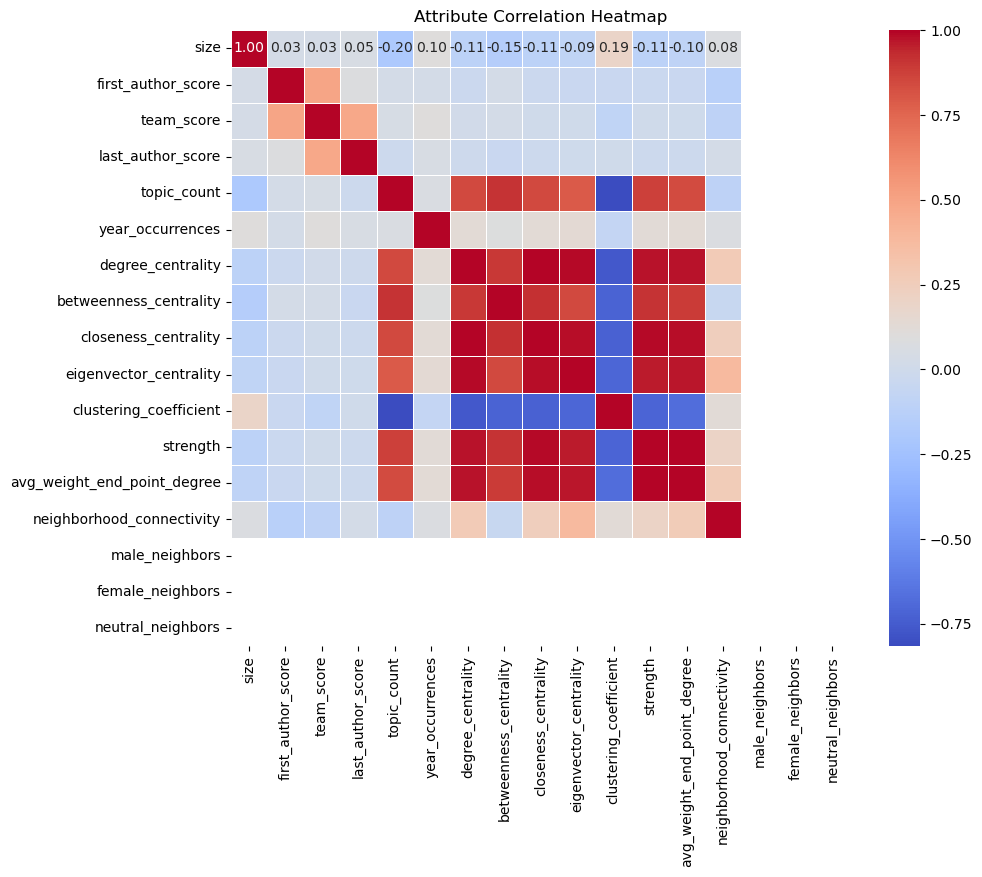

C:\Users\maria\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


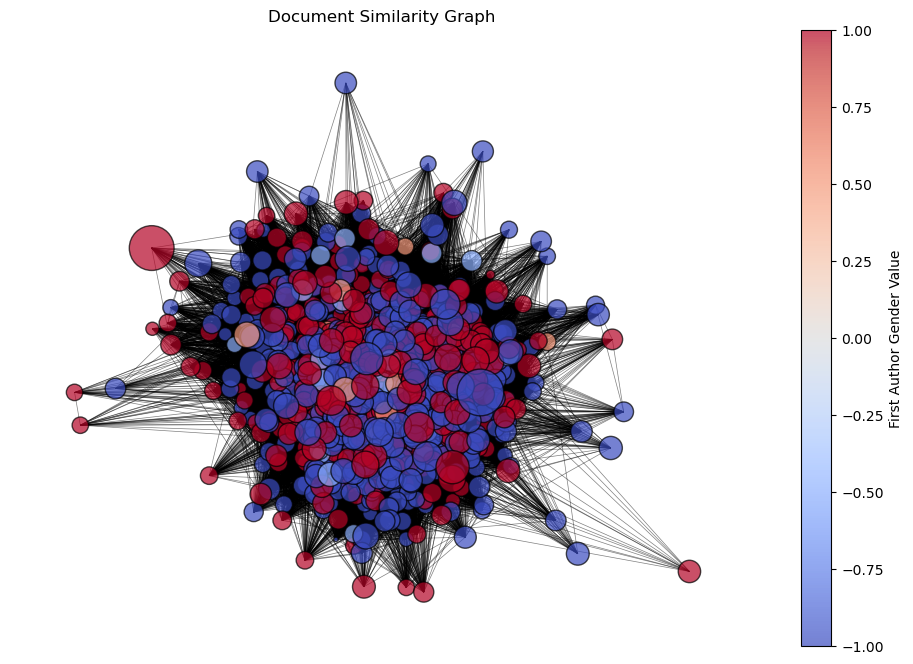

In [16]:
def build_graph_DtD_lda(df, threshold=3, min_edge_weight=0):
    '''Build (Doc) - topic - (Doc) based on dataframe'''
    G = nx.Graph()  # Initialize an undirected graph

    # Filter out topics below the threshold per row and track documents
    df['Filtered_LDA'] = df.apply(lambda row: {k: v for k, v in row['Parsed_TopicsLDA'].items() if v >= threshold}, axis=1)

    # Add nodes with attributes
    for index, row in df.iterrows():
        first_author_score = row['First_Gender_Value']
        team_score = row['Gender_Numeric_Avg']
        last_author_score = row['Last_Gender_Value']
        topic_count = len(row['Filtered_LDA'])
        topic_list = list(row['Filtered_LDA'].keys())
        year_occurrences = row['releasedDateY_i']
        color = plt.cm.coolwarm((first_author_score + 1) / 2)
        border_color = plt.cm.coolwarm((team_score + 1) / 2)

        G.add_node(index, size=row['numChunks'], first_author_score=first_author_score, 
                   team_score=team_score, last_author_score=last_author_score, 
                   topics=topic_list, topic_count=topic_count, color=color, 
                   border_color=border_color, year_occurrences=year_occurrences)

    # Mapping topics to documents
    topic_to_docs = defaultdict(list)
    for index, row in df.iterrows():
        for topic in row['Filtered_LDA']:
            topic_to_docs[topic].append(index)

    # Add edges
    for topic, docs in topic_to_docs.items():
        for doc1, doc2 in combinations(docs, 2):
            if G.has_edge(doc1, doc2):
                G[doc1][doc2]['weight'] += 1
            else:
                G.add_edge(doc1, doc2, weight=1)

    # Remove edges with weight below the minimum threshold
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_edge_weight]
    G.remove_edges_from(edges_to_remove)

    G = calculate_centrality_measures(G)

    stats_df, correlation_matrix = explore_graph(G)

    # Save heatmap of the correlation matrix
    visualization_dir = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/'
    os.makedirs(visualization_dir, exist_ok=True)
    
    heatmap_path = os.path.join(visualization_dir, 'heatmap_lda.png')
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout(pad=3.0)
    plt.savefig(heatmap_path)
    plt.close()

    # Plotting
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.1, iterations=20)

    # Determine edge weights for drawing
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Labels for top weighted edges
    top_edges = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)[:10]  # Get top 10 edges by weight
    edge_labels = {edge: weight for edge, weight in top_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Draw nodes with size and color attributes
    node_sizes = [G.nodes[node]['size'] * 10 for node in G.nodes]  # Adjust size scaling for better visibility
    node_colors = [G.nodes[node]['first_author_score'] for node in G.nodes]  # Color by first author gender value

    # Create a scatter plot for nodes
    scatter = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='coolwarm', alpha=0.7, edgecolors='black')

    # Draw edges with width proportional to weight
    edge_widths = [d['weight'] * 0.5 for u, v, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_widths)

    plt.colorbar(scatter, label='First Author Gender Value')
    
    plt.title("Document Similarity Graph")
    plt.axis('off')
    plt.show()

    return G, stats_df

# Example usage
# Ensure your 'merged_df' DataFrame is properly defined with 'Parsed_TopicsLDA' and 'numChunks' columns
dtd_lda_G, stats_dtd_lda_G = build_graph_DtD_lda(merged_df)


In [18]:
save_graph_pickle(dtd_lda_G, 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/dtd_lda_G.pkl')

Graph saved to C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/dtd_lda_G.pkl


In [19]:
stats_dtd_lda_G

,Max,Min,Average,Mode
size,113.000000,1.000000,18.177579,17.000000
first_author_score,1.000000,-1.000000,-0.132937,-1.000000
team_score,1.000000,-1.000000,-0.311328,-1.000000
last_author_score,1.000000,-1.000000,-0.433036,-1.000000
topic_count,15.000000,1.000000,5.224206,5.000000
year_occurrences,2024.000000,2006.000000,2020.502976,2020.000000
degree_centrality,0.767627,0.014896,0.392926,0.453823
betweenness_centrality,0.002697,0.000000,0.000604,0.000000
closeness_centrality,0.811442,0.497038,0.627242,0.646757
eigenvector_centrality,0.055964,0.000982,0.029402,0.006060


## DtD BERTopic
(Doc) - topic - (Doc)

Centrality measures, average weight, and neighborhood attributes added to nodes.
Total number of nodes: 1008
Total number of edges: 239539


C:\Users\maria\AppData\Local\Temp\ipykernel_7308\3960059300.py:631: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  'Mode': mode(values).mode[0] if len(mode(values).mode) > 0 else None
C:\Users\maria\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


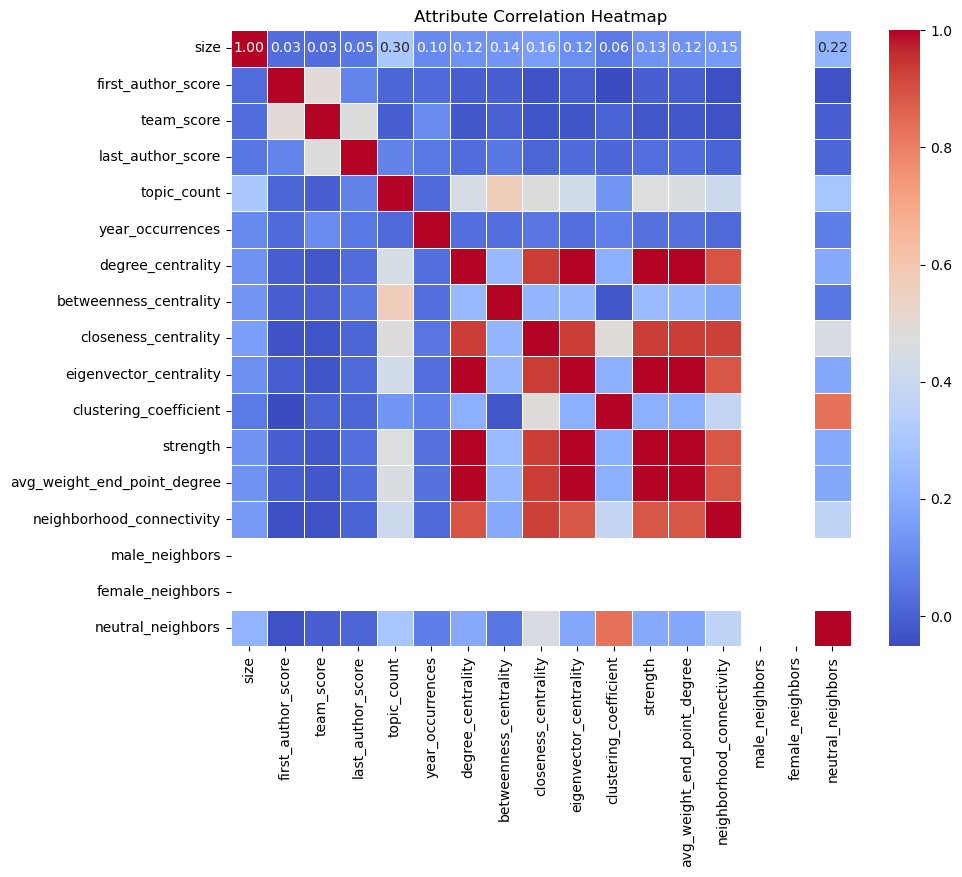

C:\Users\maria\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


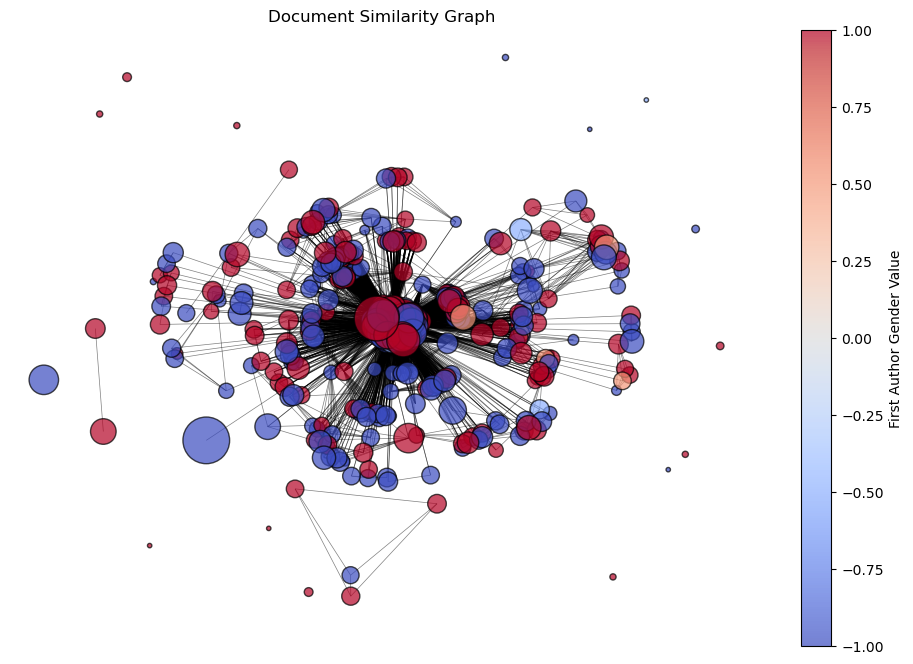

In [20]:
def build_graph_dtd_bertopic(df, threshold=3, min_edge_weight=0):
    '''Build (Doc) - topic - (Doc) based on dataframe'''
    G = nx.Graph()  # Initialize an undirected graph

    # Filter out topics below the threshold per row and track documents
    df['Filtered_BERTopic'] = df.apply(lambda row: {k: v for k, v in row['Parsed_BERTopic'].items() if v >= threshold}, axis=1)

    # Add nodes with attributes
    for index, row in df.iterrows():
        first_author_score = row['First_Gender_Value']
        team_score = row['Gender_Numeric_Avg']
        last_author_score = row['Last_Gender_Value']
        topic_count = len(row['Filtered_BERTopic'])
        topic_list = list(row['Filtered_BERTopic'].keys())
        year_occurrences = row['releasedDateY_i']
        color = plt.cm.coolwarm((first_author_score + 1) / 2)
        border_color = plt.cm.coolwarm((team_score + 1) / 2)

        G.add_node(index, title=row['fileMain_s'], size=row['numChunks'], first_author_score=first_author_score,
                   team_score=team_score, last_author_score=last_author_score, topics=topic_list,
                   topic_count=topic_count, color=color, border_color=border_color, year_occurrences=year_occurrences)

    # Mapping topics to documents
    topic_to_docs = defaultdict(list)
    for index, row in df.iterrows():
        for topic in row['Filtered_BERTopic']:
            topic_to_docs[topic].append(index)

    # Add edges
    for topic, docs in topic_to_docs.items():
        for doc1, doc2 in combinations(docs, 2):
            if G.has_edge(doc1, doc2):
                G[doc1][doc2]['weight'] += 1
            else:
                G.add_edge(doc1, doc2, weight=1)

    # Remove edges with weight below the minimum threshold
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_edge_weight]
    G.remove_edges_from(edges_to_remove)

    G = calculate_centrality_measures(G)

    stats_df, correlation_matrix = explore_graph(G)

    # Save heatmap of the correlation matrix
    visualization_dir = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/Visualizations/'
    os.makedirs(visualization_dir, exist_ok=True)
    
    heatmap_path = os.path.join(visualization_dir, 'heatmap_bertopic.png')
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout(pad=3.0)
    plt.savefig(heatmap_path)
    plt.close()

    # Plotting
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.1, iterations=20)

    # Determine edge weights for drawing
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Labels for top weighted edges
    top_edges = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)[:10]  # Get top 10 edges by weight
    edge_labels = {edge: weight for edge, weight in top_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Draw nodes with size and color attributes
    node_sizes = [G.nodes[node]['size'] * 10 for node in G.nodes]  # Adjust size scaling for better visibility
    node_colors = [G.nodes[node]['first_author_score'] for node in G.nodes]  # Color by first author gender value

    # Create a scatter plot for nodes
    scatter = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='coolwarm', alpha=0.7, edgecolors='black')

    # Draw edges with width proportional to weight
    edge_widths = [d['weight'] * 0.5 for u, v, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_widths)

    plt.colorbar(scatter, label='First Author Gender Value')
    
    plt.title("Document Similarity Graph")
    plt.axis('off')
    plt.show()

    return G, stats_df

# Example usage
# Ensure your 'merged_df' DataFrame is properly defined with 'Parsed_BERTopics' and 'numChunks' columns
dtd_bertopic_G, stats_dtd_bertopic_G = build_graph_dtd_bertopic(merged_df)





In [21]:
save_graph_pickle(dtd_bertopic_G, 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/dtd_bertopic_G.pkl')

Graph saved to C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/Graphs/dtd_bertopic_G.pkl


In [22]:
stats_dtd_bertopic_G

,Max,Min,Average,Mode
size,113.000000,1.000000e+00,18.177579,17.000000
first_author_score,1.000000,-1.000000e+00,-0.132937,-1.000000
team_score,1.000000,-1.000000e+00,-0.311328,-1.000000
last_author_score,1.000000,-1.000000e+00,-0.433036,-1.000000
topic_count,4.000000,0.000000e+00,1.362103,1.000000
year_occurrences,2024.000000,2.006000e+03,2020.502976,2020.000000
degree_centrality,0.725919,0.000000e+00,0.471972,0.679245
betweenness_centrality,0.021109,0.000000e+00,0.000578,0.000000
closeness_centrality,0.770122,0.000000e+00,0.633241,0.742128
eigenvector_centrality,0.038354,2.507751e-16,0.026176,0.038184


# Download Data

In [ ]:
#Downloading communities info

def filter_entities_and_prepare_data(df, threshold):
    '''We get the total count of remaining entities to later set is as the node size 
    and we calculate the gender avg per entity to be latter the attribute to define the color
    '''
    # Filter entities per row and prepare data for graph nodes and edges
    entity_counts = Counter()
    entity_gender_values = defaultdict(list)
    entity_gender_values_team = defaultdict(list)
    
    # Filter out entities below the threshold per row
    df['Filtered_Entities'] = df['TaxoEntities_Count'].apply(lambda x: {k: v for k, v in x.items() if v >= threshold})
    
    # Calculate total counts and average gender values for each entity
    for index, row in df.iterrows():
        entities = row['Filtered_Entities']
        entity_counts.update(entities)
        
        for entity in entities:
            entity_gender_values[entity].append(row['First_Gender_Value'])
            entity_gender_values_team[entity].append(row['Gender_Numeric_Avg'])
    
    # Calculate average gender values
    entity_avg_gender = {entity: sum(values) / len(values) for entity, values in entity_gender_values.items()}
    entity_avg_gender_team = {entity: sum(values) / len(values) for entity, values in entity_gender_values_team.items()}
    
    # Remove entities from the count and average gender value dictionaries if they don't meet the overall threshold
    entity_counts = Counter({k: v for k, v in entity_counts.items() if v >= threshold})
    entity_avg_gender = {k: v for k, v in entity_avg_gender.items() if k in entity_counts}
    entity_avg_gender_team = {k: v for k, v in entity_avg_gender_team.items() if k in entity_counts}
    
    return entity_counts, entity_avg_gender, entity_avg_gender_team

# count_threshold is the threshold for an entity to be included in the graph
count_threshold = 5
entity_counts, entity_avg_gender, entity_avg_gender_team = filter_entities_and_prepare_data(merged_df, count_threshold)


def download_dict(data_dict, avg_gender, file_name='data.xlsx'):
    # Compute the average gender score for each key in data_dict
    avg_community_gender_values = [
        np.mean([avg_gender.get(item, 0) for item in value]) if value else 0
        for value in data_dict.values()
    ]
    
    # Compute the number of elements for each key in data_dict
    num_elements_values = [len(value) for value in data_dict.values()]
    
    # Create a DataFrame from data_dict with 'Keys' and 'Values'
    df = pd.DataFrame(list(data_dict.items()), columns=['Community', 'Members'])
    
    # Add the computed average gender scores as a new column
    df['Gender_Score'] = avg_community_gender_values
    
    # Add the number of elements as a new column
    df['Num_Elements'] = num_elements_values
    
    # Save the DataFrame to an Excel file
    df.to_excel(file_name, index=False)
    
    print(f"{file_name} has been saved successfully.")
    



download_dict(ded_communities, doc_avg_gender, 'ded_communities.xlsx')
download_dict(entities_community_nodes, entity_avg_gender, 'entities_community_nodes.xlsx')
download_dict(tdt_lda_communities, LDA_topic_avg_gender, 'tdt_lda_communities.xlsx')
download_dict(tdt_bertopic_communities, BERTopic_avg_gender, 'tdt_bertopic_communities.xlsx')
download_dict(dtd_lda_communities, doc_avg_gender, 'dtd_lda_communities.xlsx')
download_dict(dtd_bertopic_communities, doc_avg_gender, 'dtd_bertopic_communities.xlsx')

In [ ]:
dtd_lda_G, stats_dtd_lda_G = build_graph_dtd_lda(merged_df, threshold=5, min_edge_weight=4 )
print_node_attributes(dtd_lda_G, 'Blue Tit')

subgraphs_genders, stats_genders = split_graph_by_gender(dtd_lda_G)
stats_genders

subgraphs_centralities, subgraphs_clustering_summary_statistics = get_subgraphs_clustering_measures(dtd_lda_G, subgraphs_genders)
subgraphs_clustering_summary_statistics

# Checking attributes added per node in gender subgraphs
print_node_attributes(subgraphs_genders['neutral'], 'Blue Tit')

plot_all_top_nodes(dtd_lda_G, top_n=20)


dtd_lda_communities, dtd_lda_clustering_measures, dtd_lda_clustering_measures_summary = analyze_multiple_community_methods(dtd_lda_G, min_clique=10, gn_splits = 3, graph_name='dtd lda')

#Verify the communities where added correctly as attributes
print_node_attributes(dtd_lda_G, 'Herbivora')

# Creating the subgraph
test_community = dtd_lda_communities['louvain']['Community 86']
subG = dtd_lda_G.subgraph(test_community)
plot_graph_with_attributes(subG, spacing_k = 0.1)